# Calculation of aco_angle_1 from low-level data

This code calculates aco_angle_1 from the pion 4-vectors, using formulas (4), (5) and (6) from the CMS CP paper.

In [1]:
# start with some setup
!pip install --user uproot
import sys
sys.path.append("/eos/home-m/dwinterb/.local/lib/python2.7/site-packages")

In [2]:
import uproot 
import numpy as np
import pandas as pd
#import matplotlib as mpl
#mpl.use('Agg')
import matplotlib.pyplot as plt
from ROOT import TLorentzVector

Welcome to JupyROOT 6.20/06


In [4]:
# read data files
tree_tt = uproot.open("/eos/user/k/kgalambo/SWAN_projects/Masters_CP_Kristof_2/MVAFILE_AllHiggs_tt.root")["ntuple"]
tree_et = uproot.open("/eos/user/k/kgalambo/SWAN_projects/Masters_CP_Kristof_2/MVAFILE_AllHiggs_et.root")["ntuple"]
tree_mt = uproot.open("/eos/user/k/kgalambo/SWAN_projects/Masters_CP_Kristof_2/MVAFILE_AllHiggs_mt.root")["ntuple"]

In [5]:
variables = [
    "wt_cp_sm", "wt_cp_ps", "wt_cp_mm", "rand",
    "aco_angle_1", 
    "mva_dm_1", "mva_dm_2",
    "tau_decay_mode_1", "tau_decay_mode_2",
#     "ip_x_1", "ip_y_1", "ip_z_1", "ip_x_2", "ip_y_2", "ip_z_2", # ignore impact parameter for now
    "pi_px_1", "pi_py_1", "pi_pz_1", "pi_E_1",
    "pi_px_2", "pi_py_2", "pi_pz_2", "pi_E_2",
    "pi0_px_1", "pi0_py_1", "pi0_pz_1", "pi0_E_1",
    "pi0_px_2", "pi0_py_2", "pi0_pz_2", "pi0_E_2",
    "y_1_1", "y_1_2"
]

In [6]:
# WARNING! This line takes a long time
df = tree_tt.pandas.df(variables)

In [7]:
df_1 = df[
      (df["tau_decay_mode_1"] == 1) 
    & (df["tau_decay_mode_2"] == 1) 
    & (df["mva_dm_1"] == 1) 
    & (df["mva_dm_2"] == 1)
    # comment some selections to help with stats
    #& (df["deepTauVsJets_medium_1"] > 0.5) 
    #& (df["deepTauVsEle_vvloose_1"] > 0.5)
    #& (df["deepTauVsMu_vloose_1"] > 0.5)
    #& (df["deepTauVsJets_medium_2"] > 0.5) 
    #& (df["deepTauVsEle_vvloose_2"] > 0.5)
    #& (df["deepTauVsMu_vloose_2"] > 0.5)
    #& (df["trg_doubletau"] > 0.5)
]

df_1 = df_1.drop(["mva_dm_1", "mva_dm_2", "tau_decay_mode_1", "tau_decay_mode_2"], axis=1).reset_index(drop=True)

df_ps = df_1[
      (df_1["rand"]<df_1["wt_cp_ps"]/2)
]

df_sm = df_1[
      (df_1["rand"]<df_1["wt_cp_sm"]/2)
]


In [10]:
def calculate_aco_angles(dataset):
    angles = []
    for i in range(len(dataset)):
        px3 = dataset["pi_px_1"].iloc[i]
        py3 = dataset["pi_py_1"].iloc[i]
        pz3 = dataset["pi_pz_1"].iloc[i]
        E3 = dataset["pi_E_1"].iloc[i]
        px4 = dataset["pi_px_2"].iloc[i]
        py4 = dataset["pi_py_2"].iloc[i]
        pz4 = dataset["pi_pz_2"].iloc[i]
        E4 = dataset["pi_E_2"].iloc[i]
        p3 = TLorentzVector(px3, py3, pz3, E3)
        p4 = TLorentzVector(px4, py4, pz4, E4)
        p3p4 = p3 + p4
        cm = p3p4.BoostVector()

        px1 = dataset["pi0_px_1"].iloc[i]
        py1 = dataset["pi0_py_1"].iloc[i]
        pz1 = dataset["pi0_pz_1"].iloc[i]
        E1 = dataset["pi0_E_1"].iloc[i]
        px2 = dataset["pi0_px_2"].iloc[i]
        py2 = dataset["pi0_py_2"].iloc[i]
        pz2 = dataset["pi0_pz_2"].iloc[i]
        E2 = dataset["pi0_E_2"].iloc[i]
        p1 = TLorentzVector(px1, py1, pz1, E1)
        p2 = TLorentzVector(px2, py2, pz2, E2)
        
        y1 = dataset["y_1_1"].iloc[i]
        y2 = dataset["y_1_2"].iloc[i]

        p3.Boost(-cm)
        p4.Boost(-cm)
        p1.Boost(-cm)
        p2.Boost(-cm)

        n1 = p1.Vect() - p1.Vect().Dot(p3.Vect().Unit())*p3.Vect().Unit()
        n2 = p2.Vect() - p2.Vect().Dot(p4.Vect().Unit())*p4.Vect().Unit()
        n1 = n1.Unit()
        n2 = n2.Unit()

        angle = np.arccos(n1.Dot(n2))
        sign = p4.Vect().Unit().Dot(n1.Cross(n2))

        # shift 1
        if sign < 0:
            angle = 2 * np.pi - angle

        # shift 2
        if y1*y2 < 0:
            if angle < np.pi:
                angle += np.pi
            else:
                angle -= np.pi

        angles.append(angle)

        if i%10000==0:
            print('finished element', i)
            
    return angles

In [16]:
sm_aco = calculate_aco_angles(df_sm)
ps_aco = calculate_aco_angles(df_ps)

finished element 0
finished element 10000
finished element 20000
finished element 30000
finished element 40000
finished element 50000
finished element 60000
finished element 70000
finished element 80000
finished element 90000
finished element 100000
finished element 110000
finished element 120000
finished element 130000
finished element 140000
finished element 150000
finished element 160000
finished element 170000
finished element 180000
finished element 190000
finished element 200000
finished element 210000
finished element 220000
finished element 230000
finished element 240000
finished element 250000
finished element 260000
finished element 270000
finished element 280000
finished element 290000
finished element 300000
finished element 310000
finished element 320000
finished element 0
finished element 10000
finished element 20000
finished element 30000
finished element 40000
finished element 50000
finished element 60000
finished element 70000
finished element 80000
finished element 90

In [12]:
# define function to plot 'signal' vs 'background' for a specified variables
# useful to check whether a variable gives some separation between
# signal and background states
def plot_signal_background(data1, data2, column,
                        bins=100, x_uplim=0, **kwargs):

    if "alpha" not in kwargs:
        kwargs["alpha"] = 0.5

    df1 = data1[column]
    df2 = data2[column]

    fig, ax = plt.subplots()
    df1 = df1.sample(3000, random_state=1234)
    df2 = df2.sample(3000, random_state=1234)
    low = max(min(df1.min(), df2.min()),-5)
    high = max(df1.max(), df2.max())
    if x_uplim != 0: high = x_uplim

    ax.hist(df1, bins=bins, range=(low,high), **kwargs)
    ax.hist(df2, bins=bins, range=(low,high), **kwargs)
    if column == "aco_angle_1":
        plt.title('given aco_angle_1 (true values)')
    else:
        plt.title(column)
    
    if x_uplim != 0:
        ax.set_xlim(0,x_uplim)

    # ax.set_yscale('log')


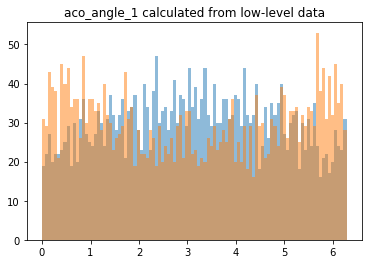

In [14]:
# plot my calculated aco_angle_1 values
sm_aco_df = pd.DataFrame(sm_aco, columns=['aco_angle_1 calculated from low-level data'])
ps_aco_df = pd.DataFrame(ps_aco, columns=['aco_angle_1 calculated from low-level data'])
plot_signal_background(sm_aco_df, ps_aco_df, 'aco_angle_1 calculated from low-level data', bins=100)

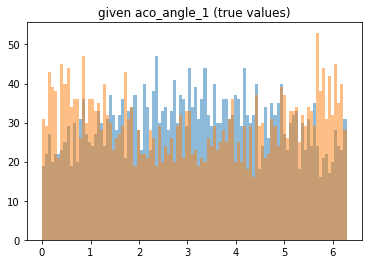

In [15]:
# plot the given aco_angle_1 values
plot_signal_background(df_sm, df_ps, 'aco_angle_1', bins=100)